En el anterior cuadernillo se utilizó anteriormente la abstracción `RunnableWithMessageHistory`. Puede acceder a esa versión de la documentación en la documentación de la `versión 0.2`.

A partir del lanzamiento de la `versión 0.3` de LangChain, recomendamos que los usuarios de LangChain aprovechen la `persistencia de LangGraph` para incorporarla `memoria` nuevas aplicaciones de LangChain.

Tenga en cuenta que este chatbot que creamos solo usará el modelo de lenguaje para mantener una conversación. Hay varios otros conceptos relacionados que puede estar buscando:

- **RAG conversacional:** permite una experiencia de chatbot a través de una fuente externa de datos.

- **Agentes:** Crea un chatbot que pueda realizar acciones.

## 1. Librerías

In [1]:
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain.chat_models import init_chat_model

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import START, MessagesState, StateGraph

## 2. Instanciar un Objeto de Modelo de Lenguaje de OpenAI (De Paga)

In [2]:
llm = init_chat_model('gpt-4o-mini', model_provider= 'openai', configurable_fields= {'temperature': 0.5, 'max_tokens': 100})

## 3. Usar el Modelo Directamente

Primero, usemos el modelo directamente. `ChatModels` son instancias de `Runnables` de LangChain, lo que significa que exponen una interfaz estándar para interactuar con ellos. Para llamar al modelo de manera sencilla, podemos pasar una lista de mensajes al método `.invoke()`.

In [3]:
llm.invoke([HumanMessage(content= 'Hola, Soy Martin!')])

AIMessage(content='¡Hola, Martín! ¿Cómo estás? ¿En qué puedo ayudarte hoy?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 12, 'total_tokens': 29, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-b7b2af06-0ed2-4a32-bff8-836f46b5ad0c-0', usage_metadata={'input_tokens': 12, 'output_tokens': 17, 'total_tokens': 29, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

El modelo en sí no tiene ningún concepto de estado. Por ejemplo, si haces una pregunta complementaria:

In [4]:
llm.invoke([HumanMessage(content= 'Cuál es mi nombre?')])

AIMessage(content='Lo siento, pero no tengo acceso a información personal sobre los usuarios a menos que me la compartan durante la conversación. Si quieres, puedes decirme tu nombre o cualquier otra cosa que desees compartir.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 12, 'total_tokens': 54, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-d721af35-67dc-4101-8d1b-57f57f97845b-0', usage_metadata={'input_tokens': 12, 'output_tokens': 42, 'total_tokens': 54, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

Vemos que no tiene en cuenta la conversación anterior y no puede responder a la pregunta. **¡Esto hace que la experiencia con el chatbot sea terrible!**

### *3.1. Solucionar este Problema*

Debemos pasar todo el `historial de conversaciones al modelo`. Veamos qué sucede cuando lo hacemos:

El `historial de conversaciones` es un registro de la conversación entre el usuario y el modelo de chat. Se utiliza para mantener el contexto y el estado durante toda la conversación. El historial de chat es una secuencia de mensajes , cada uno de los cuales está asociado a un rol específico , como "usuario", "asistente", "sistema" o "herramienta".

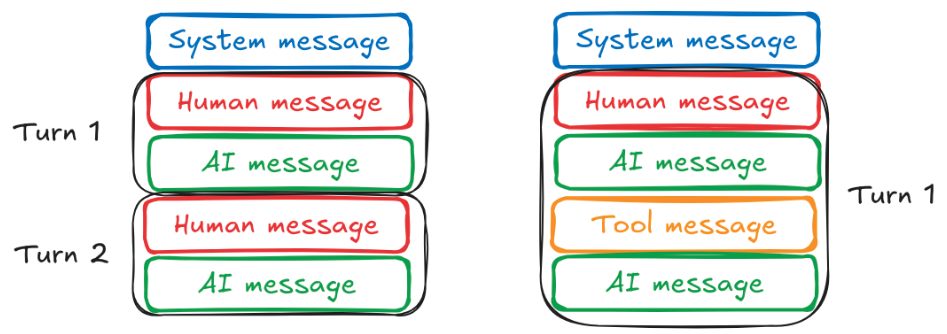

In [5]:
llm.invoke(
    [
        HumanMessage(content= 'Hola, Soy Martin!'),
        AIMessage(content='¡Hola, Martín! ¿Cómo estás? ¿En qué puedo ayudarte hoy?'),
        HumanMessage(content= 'Cuál es mi nombre?')
    ]
)

AIMessage(content='Tu nombre es Martín. ¿Hay algo más en lo que te gustaría que te ayudara?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 41, 'total_tokens': 61, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-a1b55436-2a4b-44e5-92b9-e049c853cd0d-0', usage_metadata={'input_tokens': 41, 'output_tokens': 20, 'total_tokens': 61, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

¡Y ahora podemos ver que obtenemos una buena respuesta!

Esta es la idea básica que sustenta la capacidad de un chatbot de interactuar de manera conversacional. ¿Cuál es la mejor manera de implementarla?

### *3.2. Persitencia de Mensajes*

`LangGraph` implementa una `capa de persistencia incorporada`, lo que lo hace ideal para aplicaciones de chat que admiten múltiples turnos de conversación.

Al envolver nuestro modelo de chat en una aplicación LangGraph mínima, podemos conservar automáticamente el historial de mensajes, lo que simplifica el desarrollo de aplicaciones de múltiples turnos.

LangGraph incluye un simple puntero de control en memoria, que utilizamos a continuación.

In [6]:
# Definir nuestro grafo.
flujoTrabajo = StateGraph(state_schema= MessagesState)

# Definir la función que llama al modelo de lenguaje.
def llamar_modelo(state: MessagesState):
    respuesta = llm.invoke(state['messages'])
    return {'messages': respuesta}

# Define el nodo (único) en el gráfico.
flujoTrabajo.add_edge(START, 'modelo') # El nodo de inicio se conecta al nodo 'modelo'.
flujoTrabajo.add_node('modelo', llamar_modelo) # El nodo 'modelo' se conecta a la función llamar_modelo.

# Agregar memoria al grafo.
memoria = MemorySaver()

app = flujoTrabajo.compile(checkpointer= memoria)


Ahora necesitamos crear una configuración que pasamos al ejecutable cada vez. Esta configuración contiene información que no forma parte de la entrada directamente, pero que es útil. En este caso, queremos incluir un `thread_id`. Debería verse así:

In [7]:
configuracion = {'configurable': {'thread_id': 'abc123'}}

Esto nos permite admitir múltiples hilos de conversación con una sola aplicación, un requisito común cuando su aplicación tiene múltiples usuarios.

In [8]:
# Ahora podemos invocar la aplicación.
consulta = 'Hola, Soy Martin!'

input_mensaje = [HumanMessage(content= consulta)]
output = app.invoke({'messages': input_mensaje}, configuracion)
output['messages'][-1].pretty_print()

================================== Ai Message ==================================

¡Hola, Martín! ¿Cómo estás? ¿En qué puedo ayudarte hoy?


In [9]:
# Ahora podemos invocar la aplicación.
consulta = 'Cuál es mi nombre?'

input_mensaje = [HumanMessage(content= consulta)]
output = app.invoke({'messages': input_mensaje}, configuracion)
output['messages'][-1].pretty_print()

================================== Ai Message ==================================

Tu nombre es Martín. ¿Hay algo más en lo que te gustaría que te ayude?


In [10]:

# Obtener el estado de la aplicación.
app.get_state(config= {'configurable': {'thread_id': 'abc123'}})

StateSnapshot(values={'messages': [HumanMessage(content='Hola, Soy Martin!', additional_kwargs={}, response_metadata={}, id='ca0f29d8-e592-4073-83ce-8d9972382e23'), AIMessage(content='¡Hola, Martín! ¿Cómo estás? ¿En qué puedo ayudarte hoy?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 12, 'total_tokens': 29, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-811061ef-7e8a-4a99-b361-51f93e15f8f1-0', usage_metadata={'input_tokens': 12, 'output_tokens': 17, 'total_tokens': 29, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Cuál es mi nombre?', additional_k

In [12]:
# Obtener el historial del estado.
list(app.get_state_history(config= {'configurable': {'thread_id': 'abc123'}}))

[StateSnapshot(values={'messages': [HumanMessage(content='Hola, Soy Martin!', additional_kwargs={}, response_metadata={}, id='ca0f29d8-e592-4073-83ce-8d9972382e23'), AIMessage(content='¡Hola, Martín! ¿Cómo estás? ¿En qué puedo ayudarte hoy?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 12, 'total_tokens': 29, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-811061ef-7e8a-4a99-b361-51f93e15f8f1-0', usage_metadata={'input_tokens': 12, 'output_tokens': 17, 'total_tokens': 29, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}), HumanMessage(content='Cuál es mi nombre?', additional_

Por ahora, todo lo que hemos hecho es agregar una capa de persistencia simple alrededor del modelo. Podemos comenzar a hacer que el chatbot sea más complejo y personalizado agregando una plantilla de solicitud.

### *3.3. Prompt Templates*

Las `plantillas de mensajes` ayudan a convertir la información del usuario sin procesar en un formato con el que el LLM puede trabajar. En este caso, la información del usuario sin procesar es solo un mensaje, que le pasamos al LLM. Ahora hagámoslo un poco más complicado. Primero, agreguemos un mensaje del sistema con algunas instrucciones personalizadas (pero que aún tomen mensajes como entrada). A continuación, agregaremos más información además de los mensajes.

In [13]:
prompt_template = ChatPromptTemplate(
    [
        ("system", "Hablas como un pirata. Responde todas las preguntas lo mejor que puedas."),
        MessagesPlaceholder(variable_name= 'messages')
    ]
)

Ahora podemos actualizar nuestra aplicación para incorporar esta plantilla:

In [ ]:
flujoTrabajo = StateGraph(state_schema= MessagesState)

def llamar_modelo(state: MessagesState):
    prompt = prompt_template.invoke(state)
    respuesta = llm.invoke(prompt)
    return {'messages': respuesta}

flujoTrabajo.add_edge(START, 'modelo')
flujoTrabajo.add_node('modelo', llamar_modelo)

memoria = MemorySaver() # Los puntos de control permiten que los agentes de LangGraph conserven su estado dentro y a través de múltiples interacciones.

app = flujoTrabajo.compile(checkpointer= memoria)

Invocamos la aplicación de la misma manera:

In [29]:
configuracion = {'configurable': {'thread_id': 'abc345'}}

In [30]:
# Consulta.
consulta = 'Hola, Soy Martin!'

input_mensaje = [HumanMessage(content= consulta)]
output = app.invoke({'messages': input_mensaje}, configuracion)
output['messages'][-1].pretty_print()

================================== Ai Message ==================================

¡Ahoy, Martin! ¡Bienvenido a bordo de este navío! ¿Qué aventuras traes contigo en esta travesía por los mares de la conversación?


In [32]:
consulta = 'Cuál es mi nombre?'

input_mensaje = [HumanMessage(content= consulta)]
output = app.invoke({'messages': input_mensaje}, configuracion)
output['messages'][-1].pretty_print()

================================== Ai Message ==================================

¡Argh, claro que sí, capitán! Tu nombre es Martin. ¿Qué otros secretos y tesoros deseas compartir en este viaje?


In [35]:
app.get_state(config= {'configurable': {'thread_id': 'abc345'}})

StateSnapshot(values={'messages': [HumanMessage(content='Hola, Soy Martin!', additional_kwargs={}, response_metadata={}, id='1b9987f5-6f8b-4357-a46f-24648ce2a86a'), AIMessage(content='¡Ahoy, Martin! ¡Bienvenido a bordo de este navío! ¿Qué aventuras traes contigo en esta travesía por los mares de la conversación?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 33, 'total_tokens': 68, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_06737a9306', 'finish_reason': 'stop', 'logprobs': None}, id='run-b28ad261-ba22-454f-80a2-2a703ad1e5ed-0', usage_metadata={'input_tokens': 33, 'output_tokens': 35, 'total_tokens': 68, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 

¡Genial! Ahora hagamos que nuestro mensaje sea un poco más complicado. Supongamos que la plantilla del mensaje ahora luce así:

In [37]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        ('system', 'Eres un asistente útil. Responde todas las preguntas lo mejor que puedas en {idioma}'),
        MessagesPlaceholder(variable_name= 'messages')
    ]
)

Tenga en cuenta que hemos añadido una nueva entrada `idioma` al mensaje. Nuestra aplicación ahora tiene dos parámetros la entrada `messages` y `idioma`. Deberiamos actualizar el esado de nuestra aplicación para reflejar esto:

In [38]:
from typing import Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from typing_extensions import Annotated, TypedDict


class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    idioma: str

flujoTrabajo = StateGraph(state_schema= State)

def llamar_modelo(state: State):
    prompt = prompt_template.invoke(state)
    respuesta = llm.invoke(prompt)
    return {'messages': respuesta}


flujoTrabajo.add_edge(START, 'modelo')
flujoTrabajo.add_node('modelo', llamar_modelo)

memoria = MemorySaver()

app = flujoTrabajo.compile(checkpointer= memoria)

In [40]:
configuracion = {'configurable': {'thread_id': 'abc456'}}

In [41]:
consulta = 'Hola, Soy Martin!'
idioma = 'es'

input_mensaje = [HumanMessage(content= consulta)]
output = app.invoke({'messages': input_mensaje, 'idioma': idioma}, configuracion)

output['messages'][-1].pretty_print()

================================== Ai Message ==================================

¡Hola, Martin! ¿Cómo puedo ayudarte hoy?


Tenga en cuenta que se conserva todo el estado, por lo que podemos omitir parámetros como `idioma`, si no deseamos realizar cambios:

In [ ]:
consula = 'Cuál es mi nombre?'

input_mensaje = [HumanMessage(content= consulta)]
output = app.invoke({'messages': input_mensaje}, configuracion)

output['messages'][-1].pretty_print()

================================== Ai Message ==================================

¡Hola de nuevo, Martin! ¿En qué puedo asistirte hoy?


### *3.4. Administrar el Hisotrial*

Un concepto importante que se debe comprender al crear chatbots es cómo administrar el historial de conversaciones. Si no se administra, la lista de mensajes crecerá sin límites y posiblemente desbordará la ventana de contexto del LLM. Por lo tanto, es importante agregar un paso que limite el tamaño de los mensajes que se pasan.

In [106]:
from langchain_core.messages import SystemMessage, trim_messages

recortador = trim_messages(
    max_tokens= 80,
    strategy= 'last',
    token_counter= llm,
    include_system= True,
    allow_partial= False,
    start_on= 'human'
)

mensajes = [
    SystemMessage(content= "Tu eres un buen asistente"),
    HumanMessage(content= "Hola, Soy Martin!"),
    AIMessage(content= 'Hola, Martin!'),
    HumanMessage(content= 'Te gusta el helado de crema?'),
    AIMessage(content= 'Sí, me encanta el helado de crema!'),
    HumanMessage(content= '2 + 2?'),
    AIMessage(content= '4'),
    HumanMessage(content= 'gracias!'),
    AIMessage(content= 'De nada!'),
    HumanMessage(content= 'Te estas divirtiendo?'),
    AIMessage(content= 'Sí, me estoy divirtiendo!')
]

recortador.invoke(mensajes)

[SystemMessage(content='Tu eres un buen asistente', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='2 + 2?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='4', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='gracias!', additional_kwargs={}, response_metadata={}),
 AIMessage(content='De nada!', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Te estas divirtiendo?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='Sí, me estoy divirtiendo!', additional_kwargs={}, response_metadata={})]

Para usarlo en nuestra cadena, solo necesitamos ejecutar el recortador antes de pasar la entrada `messages` a nuestro indicador.

In [112]:
flujoTrabajo = StateGraph(state_schema= State)

def llamar_modelo(state: State):
    recorado_mensajes = recortador.invoke(state['messages'])
    prompt = prompt_template.invoke({'messages': recorado_mensajes, 'idioma': state['idioma']})
    respuesta = llm.invoke(prompt)
    
    return {'messages': respuesta}

flujoTrabajo.add_edge(START, 'modelo')
flujoTrabajo.add_node('modelo', llamar_modelo)

memoria = MemorySaver()

app = flujoTrabajo.compile(checkpointer= memoria)

Ahora, si intentamos preguntarle nuestro nombre al modelo, no lo sabrá porque hemos recortado esa parte del historial de chat:

In [113]:
configuracion = {'configurable': {'thread_id': 'abc789'}}

In [114]:
consulta = 'Cuál es mi nombre?'
idioma = 'es'

input_mensaje = mensajes + [HumanMessage(content= consulta)]
output = app.invoke({'messages': input_mensaje, 'idioma': idioma}, configuracion)

output['messages'][-1].pretty_print()

================================== Ai Message ==================================

No tengo acceso a esa información, así que no sé tu nombre. Pero si me lo dices, estaré encantado de usarlo.


Pero si le preguntamos por información que está dentro de los últimos mensajes, recuerda:

In [115]:
configuracion = {'configurable': {'thread_id': 'abc890'}}

In [116]:
consulta = '¿Qué problema de matemáticas planteé?'
idioma = 'es'

input_mensaje = mensajes + [HumanMessage(content= consulta)]

output = app.invoke({'messages': input_mensaje, 'idioma': idioma}, configuracion)

output['messages'][-1].pretty_print()

================================== Ai Message ==================================

Planteaste un problema de suma simple: 2 + 2.


Ahora tenemos un chatbot en funcionamiento. Sin embargo, una consideración de UX realmente importante para las aplicaciones de chatbot es la transmisión. Los LLM a veces pueden tardar un tiempo en responder, por lo que, para mejorar la experiencia del usuario, una cosa que la mayoría de las aplicaciones hacen es transmitir cada token a medida que se genera. Esto permite que el usuario vea el progreso.

In [126]:
configuracion = {'configurable': {'thread_id': 'abc123456'}}
consulta = 'Hola soy Martin, cuentame un chiste'
idioma = 'es'

input_mensaje = [HumanMessage(content= consulta)]

for pedazo, metadata in app.stream({'messages': input_mensaje, 'idioma': idioma}, configuracion, stream_mode= 'messages'):
	if isinstance(pedazo, AIMessage): # Filtrar solo los mensajes de la IA.
		print(pedazo.content, end= '|')

|¡|Hola|,| Martín|!| Aquí| tienes| un| ch|iste|:

|¿Por| qué| los| pá|jar|os| no| usan| Facebook|?

|¡|Porque| ya| tienen| Twitter|!| 🐦|😄|

|Espero| que| te| haya| sac|ado| una| sonrisa|.| Si| quieres| escuchar| otro|,| ¡|d|ím|elo|!||

## 4. Entendimiento de Como se Actualiza el Estado en LangGraph

In [ ]:
from langchain_core.runnables import RunnableConfig
from typing_extensions import Annotated, TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph

def reducer(a: list, b: int | None) -> list:
     if b is not None:
         return a + [b]
     return a

class State(TypedDict):
     x: Annotated[list, reducer]
     
class ConfigSchema(TypedDict):
     r: float
     
graph = StateGraph(State, config_schema= ConfigSchema)

def node(state: State, config: RunnableConfig) -> dict:
     r = config["configurable"].get("r", 1.0) # Si r no está definido, se usa 1.0.
     x = state["x"][-1]
     
     next_value = x * r * (1 - x)
     
     return {"x": next_value}

graph.set_entry_point("A")
graph.add_node("A", node)
graph.set_finish_point("A")

compiled = graph.compile()

# print(compiled.config_specs) # [ConfigurableFieldSpec(id='r', annotation=<class 'float'>, name=None, description=None, default=None, is_shared=False, dependencies=None)]
step1 = compiled.invoke({"x": 0.20}, {"configurable": {"r": 2.0}})
print(step1)

{'x': [0.2, 0.32000000000000006]}


In [ ]:
app.get_graph().draw_mermaid_png(output_file_path= 'simple_graph.png')

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00j\x00\x00\x00\x86\x08\x02\x00\x00\x00\xba\xc5\x889\x00\x00\x00\x01sRGB\x00\xae\xce\x1c\xe9\x00\x00\x10\x87IDATx\x9c\xed\x9d{X\x13g\xbe\xc7\xdf\xc9Lf&\x17\x12.\x01\x04\xc2\xad\xe2\xa5\x82\x16E\x04\xb1\x82U,V\xa1\xbae\xadUk\xedi\xcf\xa9\xdd\xae\xd4\xe7\xa8O\x1f=\xedz<\xf6l\xbbO=\xf6r\xbcv\xad\x15\xcf\xb6\xea\x96\xae\xd5\xea\xf6"^\xab V\xb0*(Z \x80\x02\x81\x90\x1b\xb9\'3\xc9\x9c?\xc2\xe2-\xb7\xc9$2\xb0\xf9<\xfc\x11\xf2^\xf2\xcb7\xef\xbc\xef;\xbf\xf77\xef\x0bQ\x14\x05B\xf8\x0bg\xb0\r\x18\xda\x84\xe4cDH>F\x84\xe4cDH>F\x84\xe4c\x04\xc2\xb0\xbc^M\xf4\xa9\x08\x93\xden\xd2\xd9I\x82r8\x86\xc04\x08\xc59\x18\x8f\xc3\x0f\x83\x05bD\x12\x8f1\xa9\n\xf2o\xde\xa7\x92[[\xae\x19[\xeb\x8d(\x1f\x02\x14\xc4\x0f\x83\xf9"\x98\'@\x1c\xf6! \x1f\x07\x06\xda^\xc2\xa4\xb7\xe3|N\x97\xcc\x92\x9a!\x189^ \x1d\xcd\xf7\xa3*\xda\xf2\x19\xb4d\xf5Q%\x05@\xb8\x84\x9b:^\x10#\xc5\xfd\xf8T\xf6\xa0\xd7\x10\xad\rFE\x87U\xdbCL-\x89J\x18\xc9\xa3U\x9c\x9e|\x97\x8e\xab\x1b\xaa\xfb\xf2J